# Quora Question Pairs NLP Project 


![image.png](https://cdn-thumbnails.huggingface.co/social-thumbnails/spaces/sumaiyya/Quora-Question-Pairs.png)


# Problem Statement

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.


# About the dataset

The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.


**Data fields**

- **`id`** - the id of a training set question pair
- **`qid1, qid2`** - unique ids of each question (only available in train.csv)
- **`question1, question2`** - the full text of each question
- **`is_duplicate`** - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.


In [1]:
!pip install distance
!pip install fuzzywuzzy

You should consider upgrading via the 'C:\Users\Abhishek\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Abhishek\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('quora-question-pairs.zip', 'r')
zip_ref.extractall('/')
zip_ref.close()

In [3]:
!pip install xgboost

You should consider upgrading via the 'C:\Users\Abhishek\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


# Training Set


In [4]:
import warnings as w
w.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import distance
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [5]:
df_train = pd.read_csv('/train.csv.zip')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [7]:
df_train.sample(10, replace=True)

,id,qid1,qid2,question1,question2,is_duplicate
187522,187522,285786,278287,What is the work of an Associate Software Engi...,What is it like to work as an Associate Softwa...,0
115022,115022,187639,187640,How do you convert Chinese to US shoe sizes?,How can I convert between European and US shoe...,0
151775,151775,238577,238578,How many peer-reviewed journal articles are co...,What would you do if your business competitor ...,0
316247,316247,33015,441257,What are the chances that Sony will last into ...,What are the chances that IBM will last into t...,0
255120,255120,369975,76236,Is carbon fiber cheaper or more expensive than...,Why can bamboo carbon fiber bristle be biodegr...,0
366101,366101,496256,9708,Should I read any programming books to learn C...,What are the best C++ books?,0
326624,326624,452955,452956,If I drink milk right after drinking orange ju...,Can you drink milk and juice together (or one ...,0
39643,39643,71847,71848,Why do women have a wardrobe full of clothes b...,Why is it wrong for a heterosexual man to wear...,0
373522,373522,504337,504338,What manga would you recommend that has a soft...,"What are anime(s) with art style similar to ""M...",0
111866,111866,183126,183127,Have the disabled children been adequately add...,Does the US take adequate care of its service ...,0


- You saw the this are the same qustions
    - 1. What's the best Tor Browser app for iOS?  2. What is the best Tor browser app for iPhone?
    - 1. How is the life being an IPS officer?      2. Is the life of an IPS officer good or not?

- And this is not same qustions
   - 1. How can I recover photos from old gmail account?  2.How do I recover my Gmail account

In [8]:
# 'id' columns have no use remove it
df_train.drop('id',axis=1,inplace=True)

In [9]:
df_train.head()

,qid1,qid2,question1,question2,is_duplicate
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


0    255027
1    149263
Name: is_duplicate, dtype: int64

0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64



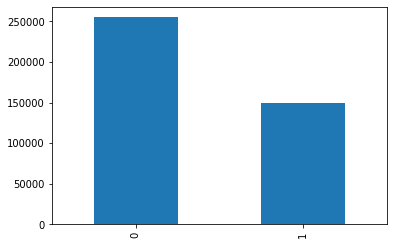

In [10]:
# Distribution of duplicate and non-duplicate questions

print(df_train['is_duplicate'].value_counts())
print()

# Persentage
print((df_train['is_duplicate'].value_counts(normalize=True))*100)
print()
# Visualization
(df_train['is_duplicate'].value_counts()).plot(kind='bar')
plt.show()

In [11]:
# missing values
df_train.isnull().sum()

qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [12]:
# remove all null values
df_train = df_train.dropna()

In [13]:
# check duplicate
df_train.duplicated().sum()

0

In [14]:
# Repeated questions
# the 'question1' column convert the list
a = df_train['question1'].tolist()
a[:10]

['What is the step by step guide to invest in share market in india?',
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
 'How can I increase the speed of my internet connection while using a VPN?',
 'Why am I mentally very lonely? How can I solve it?',
 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?',
 'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
 'Should I buy tiago?',
 'How can I be a good geologist?',
 'When do you use シ instead of し?',
 'Motorola (company): Can I hack my Charter Motorolla DCX3400?']

In [15]:
# the 'question2' column convert the list
b = df_train['question2'].tolist()
b[:10]

['What is the step by step guide to invest in share market?',
 'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?',
 'How can Internet speed be increased by hacking through DNS?',
 'Find the remainder when [math]23^{24}[/math] is divided by 24,23?',
 'Which fish would survive in salt water?',
 "I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",
 'What keeps childern active and far from phone and video games?',
 'What should I do to be a great geologist?',
 'When do you use "&" instead of "and"?',
 'How do I hack Motorola DCX3400 for free internet?']

In [16]:
# length list a and b
len(a) ,len(b)

(404287, 404287)

In [17]:
l1 = ['a','b','c']
l2 = ['d','e','f']
l1+l2

['a', 'b', 'c', 'd', 'e', 'f']

In [18]:
qus1_and_qus2 = a+b
len(qus1_and_qus2)

808574

Totle_Qustions = qus1 + qus2

In [19]:
qus1_and_qus2[:10]

['What is the step by step guide to invest in share market in india?',
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
 'How can I increase the speed of my internet connection while using a VPN?',
 'Why am I mentally very lonely? How can I solve it?',
 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?',
 'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
 'Should I buy tiago?',
 'How can I be a good geologist?',
 'When do you use シ instead of し?',
 'Motorola (company): Can I hack my Charter Motorolla DCX3400?']

In [20]:
totle_qus = pd.Series(qus1_and_qus2)
totle_qus.head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

In [21]:
# unique qustions
print('Totle unique qustions:',np.unique(totle_qus).shape[0])

Totle unique qustions: 537359


In [22]:
# common qustions
x = totle_qus.value_counts() > 1
x

What are the best ways to lose weight?                                                     True
How can you look at someone's private Instagram account without following them?            True
How can I lose weight quickly?                                                             True
What's the easiest way to make money online?                                               True
Can you see who views your Instagram?                                                      True
                                                                                          ...  
How much do toucans eat in a day? What do they eat?                                       False
Is it a logical move for Kiip.me to grow their business on the Mountain Lion platform?    False
Is Hla b27 curable?                                                                       False
Why are passports different colours?                                                      False
What is it like to have sex with your co

In [23]:
print('number of qustions repeated:',x[x].shape[0])

number of qustions repeated: 111870


In [24]:
# this operation is done only few lines
# Repeated questions

totle_qus = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist())
print('Number of unique questions',np.unique(totle_qus).shape[0])
x = totle_qus.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 537359
Number of questions getting repeated 111870


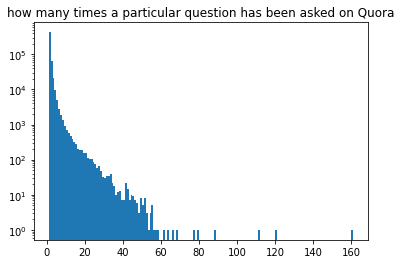

In [25]:
# Repeated questions histogram

plt.hist(totle_qus.value_counts().values,bins=160)
plt.yscale('log')
plt.title('how many times a particular question has been asked on Quora')
plt.show()

# Simple Approach:
The objective of this simple approach is to build a basic Duplicate Question Pair Identification system using a Bag-of-Words representation and a basic machine learning classifier.

-  `question1` , `question2` perform the Bag-of-Words (BoW)
- is_duplicated is y


**This Dataset is very larege my pc not working as well then i decide the only 30000 rows ranomly and perform the all operations**

In [26]:
new_df = df_train.sample(10000)

In [27]:
new_df.isnull().sum()

qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [28]:
new_df.duplicated().sum()

0

In [29]:
# extrect the 'question1','question2'  columns and store new dataset 'simple_df'
simple_df = new_df[['question1','question2']]
simple_df.head()

,question1,question2
403186,Why isn't internet free?,Why should the internet be free?
36828,Which is a suitable solar panel installation p...,Which is a suitable solar panel installation p...
198929,How do I prepare for IEO exam?,How do I stay motivated to crack iit?
256441,Will The Big Bang Theory end after season 10?,"Will ""The Big Bang Theory"" end in 2017, after ..."
247708,What tool/gadgets you use to be a productive t...,What tool/gadgets you use to be a productive m...


In [30]:
# perform the Bag-of-Words (BoW)

from sklearn.feature_extraction.text import CountVectorizer

# merge texts
questions = (list(simple_df['question1']) + list(simple_df['question2']))


In [31]:
cv = CountVectorizer(max_features=3000)

In [32]:
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [33]:
temp_df1 = pd.DataFrame(q1_arr, index= simple_df.index)



In [34]:
temp_df2 = pd.DataFrame(q2_arr, index= simple_df.index)

In [35]:

temp_df = pd.concat([temp_df1, temp_df2], axis=1)

In [36]:
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
403186,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
256441,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
247708,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [37]:
temp_df['is_duplicate'] = new_df['is_duplicate']

In [38]:
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
403186,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
256441,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
247708,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [39]:
X = temp_df.drop('is_duplicate',axis=1)
y = temp_df['is_duplicate']

In [40]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
403186,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
256441,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
247708,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [41]:
y.head()

403186    0
36828     0
198929    0
256441    1
247708    0
Name: is_duplicate, dtype: int64

In [42]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.717

In [44]:
# remove any duplicated columns/feature name
X_test = X_test.loc[:,~X_test.columns.duplicated()]
X_train = X_train.loc[:,~X_train.columns.duplicated()]

In [45]:
X_train.shape

(8000, 3000)

In [46]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.6715

Remember, this simple approach is a good starting point,
this given the idea about basic accuracy the model

Now we get some idea about the data, like how it looks and what irregularities it holds that we must overcome. So after this, if you train a machine learning model like Random Forest or XGboost by vectorizing the question, then approximately you will get 70 percent of accuracy. So we aim to use feature engineering techniques and try to improve the model performance.

# Feature Engineering

Feature engineering is a classic way of adding new features to the data that dominates to predict output variables and improve the model’s accuracy. A crucial feature creates a direct impact on the model. Feature engineering consists of transformation, scaling, feature extraction, feature encoding, EDA, etc.

We will add 7 more features to our existing dataset. The bag of words model for questions 1 and 2 questions 2 will produce different features that will be passed to the Machine learning model after Exploratory analysis.

In [47]:
new_df.head()


,qid1,qid2,question1,question2,is_duplicate
403186,190808,536756,Why isn't internet free?,Why should the internet be free?,0
36828,67112,67113,Which is a suitable solar panel installation p...,Which is a suitable solar panel installation p...,0
198929,99137,149531,How do I prepare for IEO exam?,How do I stay motivated to crack iit?,0
256441,93169,208673,Will The Big Bang Theory end after season 10?,"Will ""The Big Bang Theory"" end in 2017, after ...",1
247708,360991,360992,What tool/gadgets you use to be a productive t...,What tool/gadgets you use to be a productive m...,0


0    6250
1    3750
Name: is_duplicate, dtype: int64

0    62.5
1    37.5
Name: is_duplicate, dtype: float64



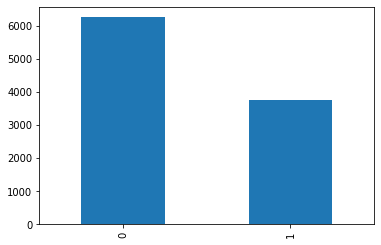

In [48]:
# Distribution of duplicate and non-duplicate questions

print(new_df['is_duplicate'].value_counts())
print()

# Persentage
print((new_df['is_duplicate'].value_counts(normalize=True))*100)
print()
# Visualization
new_df['is_duplicate'].value_counts().plot(kind='bar')
plt.show()

### Feature 1: Question Length
The size of the question is a critical feature because when we vectorize it, the question gets split by words, so having the length feature is good. The length we are having is the character-wise length. So it will create 2 new features for the length of questions 1 and 2.



In [49]:
new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()
new_df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
403186,190808,536756,Why isn't internet free?,Why should the internet be free?,0,24,32
36828,67112,67113,Which is a suitable solar panel installation p...,Which is a suitable solar panel installation p...,0,85,84
198929,99137,149531,How do I prepare for IEO exam?,How do I stay motivated to crack iit?,0,30,37
256441,93169,208673,Will The Big Bang Theory end after season 10?,"Will ""The Big Bang Theory"" end in 2017, after ...",1,45,56
247708,360991,360992,What tool/gadgets you use to be a productive t...,What tool/gadgets you use to be a productive m...,0,53,52


### Feature 2: Number of Words
The number of words in both questions is another feature that should impact the model performance. So, it will add 2 new features for questions 1 and 2. To add the feature, split the sentence with space and extract the length of the list

In [50]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
403186,190808,536756,Why isn't internet free?,Why should the internet be free?,0,24,32,4,6
36828,67112,67113,Which is a suitable solar panel installation p...,Which is a suitable solar panel installation p...,0,85,84,12,12
198929,99137,149531,How do I prepare for IEO exam?,How do I stay motivated to crack iit?,0,30,37,7,8
256441,93169,208673,Will The Big Bang Theory end after season 10?,"Will ""The Big Bang Theory"" end in 2017, after ...",1,45,56,9,11
247708,360991,360992,What tool/gadgets you use to be a productive t...,What tool/gadgets you use to be a productive m...,0,53,52,9,9


## Feature 3: Common Words
Another feature is to know how many common words there are in both questions. It helps identify the similarity between both questions. Calculating where you only need to apply the intersection between both questions is simple. For this, we find the number of unique words in both questions and apply the set intersection to the set length.


In [51]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
403186,190808,536756,Why isn't internet free?,Why should the internet be free?,0,24,32,4,6,3
36828,67112,67113,Which is a suitable solar panel installation p...,Which is a suitable solar panel installation p...,0,85,84,12,12,11
198929,99137,149531,How do I prepare for IEO exam?,How do I stay motivated to crack iit?,0,30,37,7,8,3
256441,93169,208673,Will The Big Bang Theory end after season 10?,"Will ""The Big Bang Theory"" end in 2017, after ...",1,45,56,9,11,7
247708,360991,360992,What tool/gadgets you use to be a productive t...,What tool/gadgets you use to be a productive m...,0,53,52,9,9,8


### Feature 4: Total Words

The sum of the total number of unique words in each question. In simple terms, find the number of unique words in both questions and return their sum.

In [52]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return (len(w1) + len(w2))

new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
403186,190808,536756,Why isn't internet free?,Why should the internet be free?,0,24,32,4,6,3,10
36828,67112,67113,Which is a suitable solar panel installation p...,Which is a suitable solar panel installation p...,0,85,84,12,12,11,24
198929,99137,149531,How do I prepare for IEO exam?,How do I stay motivated to crack iit?,0,30,37,7,8,3,15
256441,93169,208673,Will The Big Bang Theory end after season 10?,"Will ""The Big Bang Theory"" end in 2017, after ...",1,45,56,9,11,7,20
247708,360991,360992,What tool/gadgets you use to be a productive t...,What tool/gadgets you use to be a productive m...,0,53,52,9,9,8,18


 ### Feature 5: Words Share
It is one exciting feature and simple to add. To calculate, divide the common words by the total number of words.

In [53]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
403186,190808,536756,Why isn't internet free?,Why should the internet be free?,0,24,32,4,6,3,10,0.30
36828,67112,67113,Which is a suitable solar panel installation p...,Which is a suitable solar panel installation p...,0,85,84,12,12,11,24,0.46
198929,99137,149531,How do I prepare for IEO exam?,How do I stay motivated to crack iit?,0,30,37,7,8,3,15,0.20
256441,93169,208673,Will The Big Bang Theory end after season 10?,"Will ""The Big Bang Theory"" end in 2017, after ...",1,45,56,9,11,7,20,0.35
247708,360991,360992,What tool/gadgets you use to be a productive t...,What tool/gadgets you use to be a productive m...,0,53,52,9,9,8,18,0.44


# Exploratory Analysis of Newly Added Features

We have introduced some new features in the dataset, and it is an excellent time to analyze the relationship and their spread with the target variable.

#### 1. Distribution of Questions
We will analyze the length of the question, like the average length of each question in 1 and 2. Minimum and maximum number of characters. So plot the distribution plot for questions 1 and 2.

minimum characters 1
maximum characters 304
average num of characters 59


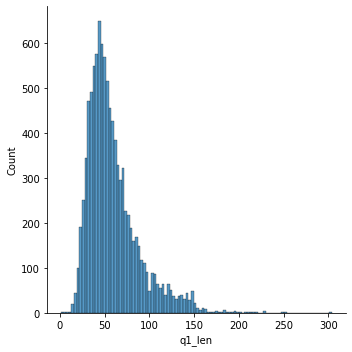

In [54]:
sns.displot(new_df['q1_len'])
print('minimum characters',new_df['q1_len'].min())
print('maximum characters',new_df['q1_len'].max())
print('average num of characters',int(new_df['q1_len'].mean()))

minimum characters 12
maximum characters 1169
average num of characters 60


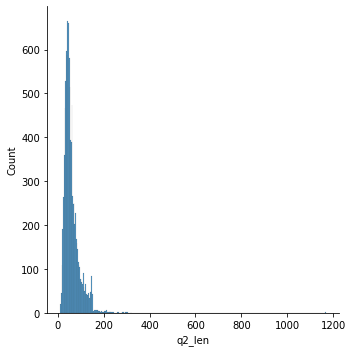

In [55]:
# q2
sns.displot(new_df['q2_len'])
print('minimum characters',new_df['q2_len'].min())
print('maximum characters',new_df['q2_len'].max())
print('average num of characters',int(new_df['q2_len'].mean()))

#### 2. Distribution of the Number of Words
Generate the same graphical analysis for the average, minimum, or maximum number of words in each question we have done.



minimum words 1
maximum words 60
average num of words 10


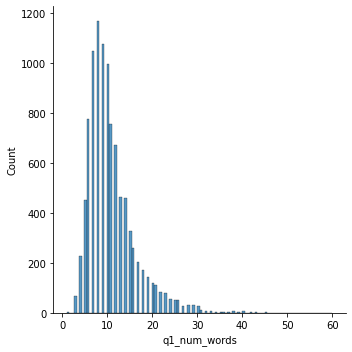

In [56]:
# q1
sns.displot(new_df['q1_num_words'])
print('minimum words',new_df['q1_num_words'].min())
print('maximum words',new_df['q1_num_words'].max())
print('average num of words',int(new_df['q1_num_words'].mean()))

minimum words 2
maximum words 228
average num of words 11


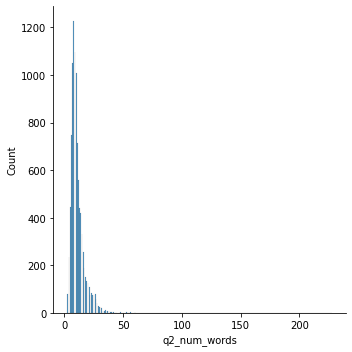

In [57]:
# q2
sns.displot(new_df['q2_num_words'])
print('minimum words',new_df['q2_num_words'].min())
print('maximum words',new_df['q2_num_words'].max())
print('average num of words',int(new_df['q2_num_words'].mean()))

#### 3. Common Words Analysis
We will plot the distribution of common words in questions 1 and 2. In this distribution plot, we will have a separate curve of non-duplicate and vice-versa

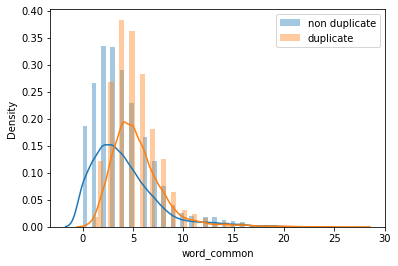

In [58]:
# common words
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_common'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_common'],label='duplicate')
plt.legend()
plt.show()

**Note : The blue one is a non-duplicate, and the orange curve, respectively. According to the graph, non-duplicate predictions are more likely if the number of common terms exceeds 4.**

#### 4. Total Words Analysis

The same analysis for total words against target variable unique entries.

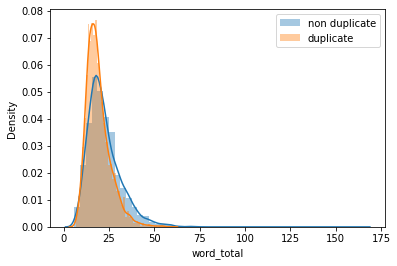

In [59]:
# total words
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

**Records will be duplicated if the total word count is between 0 and 20, but if it is more significant than 40, the model gives high weightage to non-duplicates.**

#### 5. Words Share Analysis
Plot the distribution plot for duplicate and non-duplicate against the words share column.

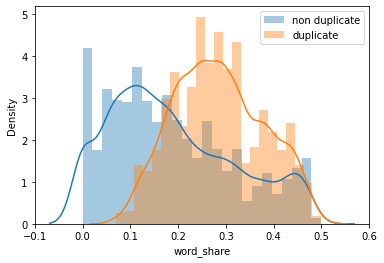

In [60]:
# word share
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

**A non-duplicate is likely to occur if the words share value is less than 0.2, but duplication occurs if the word’s share value is more significant than 0.2.**

# Machine Learning Model Creation

After performing the above EDA, we gain the confidence to keep the features in our dataset and move to the modelling part.

### 1. Separate the Independent and Dependent features
First, we need to drop the unnecessary columns and pick the columns needed for training and one target feature (dependent). So we will pick questions in different dataframe for vectorizing and other features in another dataframe with the target variable. And concat them after vectorizing.

In [61]:
ques_df = new_df[['question1','question2']]
ques_df.head()



,question1,question2
403186,Why isn't internet free?,Why should the internet be free?
36828,Which is a suitable solar panel installation p...,Which is a suitable solar panel installation p...
198929,How do I prepare for IEO exam?,How do I stay motivated to crack iit?
256441,Will The Big Bang Theory end after season 10?,"Will ""The Big Bang Theory"" end in 2017, after ..."
247708,What tool/gadgets you use to be a productive t...,What tool/gadgets you use to be a productive m...


In [62]:
final_df = new_df.drop(columns=['qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(10000, 8)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
403186,0,24,32,4,6,3,10,0.30
36828,0,85,84,12,12,11,24,0.46
198929,0,30,37,7,8,3,15,0.20
256441,1,45,56,9,11,7,20,0.35
247708,0,53,52,9,9,8,18,0.44


### 2. Vectorizing the Feature
We need to turn the questions into numerical ones because we can’t provide the string to the model. To do this, we employ a variety of feature vectorizing techniques; for the moment, we’ll use a bag of words (BOW). The bow is a technique for extracting characteristics from text input for machine learning algorithms. It displays the text that describes words’ behavior in the corpus, which entails two things. The first is words’ vocabulary (unique words in the corpus added as a new feature), and the second is a way to count the number of known words (represent the word’s presence in that query using binary format)

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

#Apply Bag of words model
cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

#Create dataFrame for both the questions Feature
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

#Concat vectorize dataframe with our newly added feature Df
final_df = pd.concat([final_df, temp_df], axis=1)
print('final_df Shape:',final_df.shape)
final_df.head()

final_df Shape: (10000, 6008)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,0,1,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
403186,0,24,32,4,6,3,10,0.30,0,0,...,0,0,0,0,0,0,0,0,0,0
36828,0,85,84,12,12,11,24,0.46,0,0,...,0,0,0,0,0,0,0,0,0,0
198929,0,30,37,7,8,3,15,0.20,0,0,...,0,0,0,0,0,0,0,0,0,0
256441,1,45,56,9,11,7,20,0.35,0,1,...,0,0,0,0,0,0,0,0,0,0
247708,0,53,52,9,9,8,18,0.44,0,0,...,0,1,0,0,0,0,0,0,0,0


In [64]:
X = final_df.drop('is_duplicate',axis=1)
y = final_df['is_duplicate']

The bag of words for each question has generated 3000 features, generating 6000 for both questions. We have 7 newly added features, making 6007 features the independent variables and one target variable dependent.

### 3. Train – Test Split
For calculating the performance of the model, we need some amount of data that the model has not seen as a test set, so we will split the final dataframe into two parts, training and test set, where 80 percent of data in the train set and 20 percent for the test set.

In [65]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X , y , test_size=0.2 , random_state=42)

In [66]:
print(X_train.shape)
print(X_test.shape)

(8000, 6007)
(2000, 6007)


In [67]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

### 4. Train the Machine Learning Models
To determine which model works the best, we will train XGboost, and Random Forest both models.

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.743

In [69]:
# remove any duplicated columns/feature name
X_test = X_test.loc[:,~X_test.columns.duplicated()]
X_train = X_train.loc[:,~X_train.columns.duplicated()]
print(X_train.shape)
print(X_test.shape)

(8000, 3007)
(2000, 3007)


In [70]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.746

### 5. Analyzing Model Performance
Random forest performs the best, and we can estimate that adding seven more characteristics improves performance by 3 to 3.5 percent

# Optimizing the Current Model Performance
The main work now is increasing the model performance and getting a well-generalized model. therefore far, we have not performed any text preprocessing, so from now we will perform **text mining** and analyze the text in different ways to generate some advanced features, which we can say is **Advance feature engineering**. The feature I have found through multiple notebooks available on Kaggle is that the features are represented as Magic. So for this, we will again load the data in a new dataframe because we will clean the text and calculate all features again.

In [71]:
import re
from bs4 import BeautifulSoup

df = pd.read_csv('/train.csv.zip')
new_df = df.sample(10000,random_state=2)

# Text Preprocessing

 The first step is to clean up the text and rectify the dataset by removing the irregularities in regular NLP Projects. As a result, we will do the following **text-cleaning processes.**

- **Lowercase:** If the text falls into one case, it is simple to vectorize and interpret because the vectorizer considers token and Token to be different words. So we will convert the entire text into lowercase.

- **String Equivalents:** The text contains multiple symbols, so we will replace them with corresponding string words.

- **Expand Contraction:** Contraction is written communication in human language to write words in short form. For example, don’t stands for do not so there are multiple contractions which we need to change to corresponding complete forms.

- **Remove HTML tags:** The text contains some unnecessary HTML tags, so that we will remove them.

- **Remove Punctuation:** Punctuation is unnecessary and does not convey meaning, so it is better to remove them.

Below is the code snippet for the question that performs all the operations while calling a function.

In [72]:
def preprocess(q):

    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()


    return q

In [73]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [74]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

# Add the Past 7  Features

The features we have added above during basic feature engineering will again run that cell to update the values in the dataframe. So I am not adding the past code again; you only need to rerun the code cell to see the upgraded dataframe. And if you have created a new notebook or again working with loading data, copy the old code and run it.

- Feature 1: Question Length
- Feature 2: Number of Words
- Feature 3: Common Words
- Feature 4: Total Words
- Feature 5: Words Share

In [75]:
# Feature 1: Question Length
new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()
new_df.head()


# Feature 2: Number of Words
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()


# Feature 3: Common Words
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()


# Feature 4: Total Words
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return (len(w1) + len(w2))

new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

# Feature 5: Words Share
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26,0.46
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24,0.33
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38,0.11
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34,0.03
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13,0.23


# Advance Feature Engineering

## 1. Token Based Features
Tokens are chunks of words that unite to form a sentence. A single word is a Token so we will add some of the features at the token level or that will help to calculate some valuable columns.

- **Cwc min** – It represents the number of common words with a minimum number of words in more minor questions.
- **Cwc max**- represents the number of common words to a maximum number of words in a larger question.
- **Csc min** – It represents the number of common stop words to the smaller stop word count among two questions.
- **Csc max** - represents the number of common stop words to the larger count among two questions.
- **Ctc min** – The number of standard tokens to count more minor tickets among two questions.
- **Ctc max** – The number of standard tokens to count more significant tokens among two questions.
- **Last word equal** – The binary feature includes the value 1 if the last word of both questions is the same, else 0.
- **The first word equal** – If the first word of both questions is equal then the value is 1. Else 0.

In [76]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):

    q1 = row['question1']
    q2 = row['question2']

    SAFE_DIV = 0.0001

    STOP_WORDS = stopwords.words("english")

    token_features = [0.0]*8

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))


    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features

In [77]:
# import nltk
# nltk.download('all')

In [78]:
# import nltk
# nltk.download('stopwords')

In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

In [80]:
#call the func and get the list of each row- of len 8
token_features = new_df.apply(fetch_token_features, axis=1)

#add the respective value in the dataframe
new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [81]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,26,0.46,0.874989,0.874989,0.999980,0.999980,0.923070,0.923070,1,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,24,0.33,0.666644,0.499988,0.714276,0.624992,0.583328,0.466664,1,1
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,38,0.11,0.000000,0.000000,0.428565,0.272725,0.149999,0.115384,0,0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,34,0.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,13,0.23,0.749981,0.599988,0.000000,0.000000,0.599988,0.333330,1,0


## 2. Length Based Features

- **Mean Length**

It is an essential but crucial feature where we will find the average of both questions’ length, known as the mean length of both questions. For example, if the first question is 8 characters in length and the second is 6 characters in length, then the average becomes 14 divided by 2 equals 7, so the mean is 7.


- **Absolute Length Difference**

The absolute difference between the length of the two questions (length of words)


- **Longest Substring Ratio**

The ratio of the length of the longest substring between two questions is divided by the length of the smaller questions. The first thing is you need to find the substring in both questions and determine the longest one and then divide it with a length of a small token sentence.

In [82]:
! pip install distance

import distance

def fetch_length_features(row):

    q1 = row['question1']
    q2 = row['question2']

    length_features = [0.0]*3

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

    return length_features


You should consider upgrading via the 'C:\Users\Abhishek\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [83]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [84]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.874989,0.999980,0.999980,0.923070,0.923070,1,1,0,13.0,0.855263
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.499988,0.714276,0.624992,0.583328,0.466664,1,1,3,13.5,0.224490
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,0.000000,0.428565,0.272725,0.149999,0.115384,0,0,6,23.0,0.047619
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,17,21.5,0.050847
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.599988,0.000000,0.000000,0.599988,0.333330,1,0,4,7.0,0.542857


## 3. Fuzzy Features
These are some features that are generated using the fuzzy-wuzzy library. To get important about this feature


In [85]:
# !pip install fuzzywuzzy

from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [86]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [87]:
print(new_df.shape)
new_df.head()


(10000, 28)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.923070,1,1,0,13.0,0.855263,99,99,99,99
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.466664,1,1,3,13.5,0.224490,69,67,65,74
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,0.115384,0,0,6,23.0,0.047619,26,29,34,43
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,0.000000,0,0,17,21.5,0.050847,29,41,23,30
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.333330,1,0,4,7.0,0.542857,55,70,48,69


# EDA of Newly Created Features
We have added nearly 23 new features to our dataset, so before modeling, we want to be confident that these features would dominate the prediction of output variables, so we run some analysis to identify specific patterns.

### 1. Minimum Variables with Target Variable
The feature we have added as a minimum calculation against the target feature to see how they affect record duplication.


<Figure size 720x720 with 0 Axes>

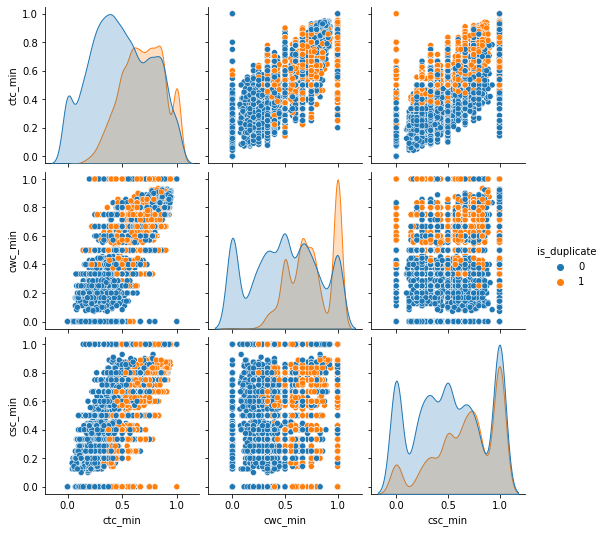

In [88]:
plt.figure(figsize=(10,10))
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

**We can differentiate between duplicate and non-duplicate. In starting maximum, the blue curve dominates, and after that orange curve dominates**

### 2. Maximum Variable with Target Variable

We have also appended the maximum calculation, so let us plot them against target variables.

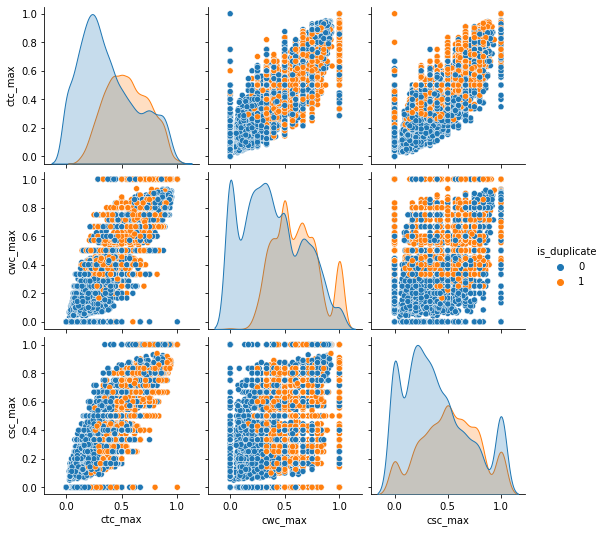

In [89]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

**We can see that the blue curve is the most dominant, and the features look helpful in predicting the output.**

### 3. Last Word and First Word Analysis
We plot the first and last word match against the target variable.

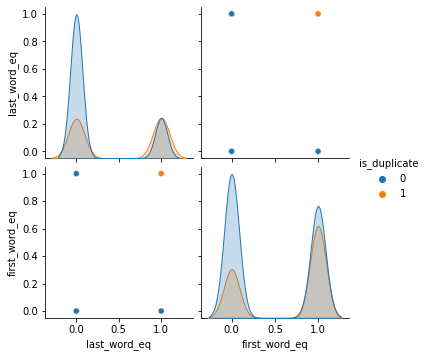

In [90]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

**We can see that if the last word does not match, there is a good chance that the question has not been copied. Similarly, if the first word is not equal, the likelihood of non-duplicate is high.**

### 4. Length-based Feature Analysis

The mean length and the absolute curve do not give much information because both the curves are moving almost together, but the most extended substring feature is beneficial where a blue curve is dominating

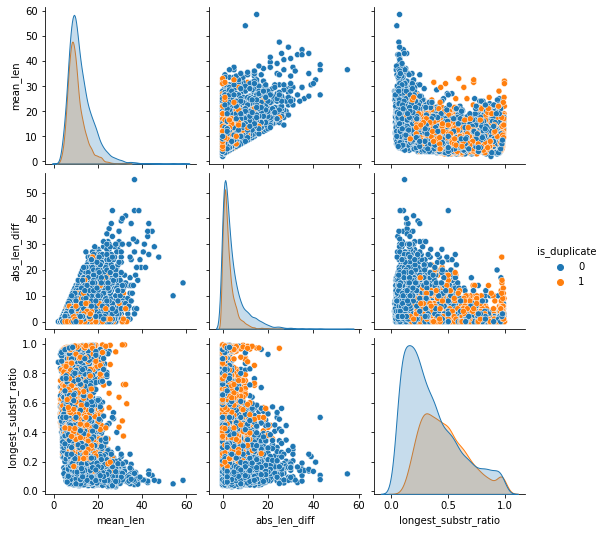

In [91]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio',
        'is_duplicate']],hue='is_duplicate')

### 5. Fuzzy Feature Analysis

All 4 features give a good understanding of the output variables, which can be useful.

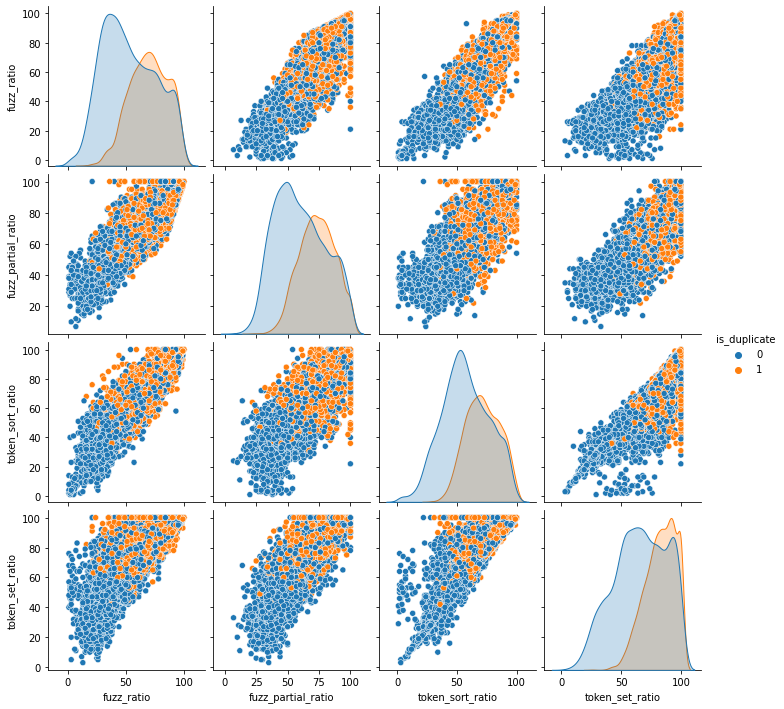

In [92]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio',
        'token_set_ratio', 'is_duplicate']],hue='is_duplicate')

# Dimensionality Reduction

We will employ TSNE (T-distributed stochastic neighbor Embedding), a non-linear unsupervised dimensionality reduction technique for data exploration and visualization. First, we’ll plot the data on the 2D graph. Then, we’ll use it to visualize the data in 3-D, allowing you to see the impact of 15 features on the target variable. Visit the notebook to get the code for the plotly 3-D view.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.031s...
[t-SNE] Computed neighbors for 10000 samples in 1.389s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.116478
[t-SNE] Computed conditional probabilities in 0.362s
[t-SNE] Iteration 50: error = 96.3760376, gradient norm = 0.0466742 (50 iterations in 4.001s)
[t-SNE] It

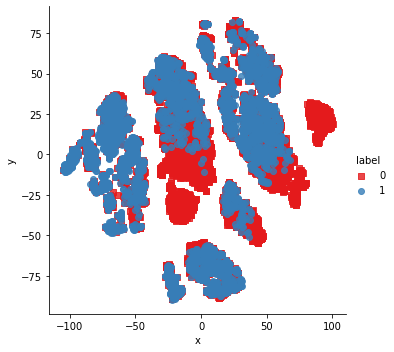

In [93]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention


from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_df['is_duplicate'].values

#train
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

#visualize
x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False,
            palette="Set1",markers=['s','o'])




**We can see from the graph that the explanation between 0 and 1 is causing the difference and impacting adding the 15 new features to the data**

# Machine Learning Modeling Part

In [94]:
ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
398782,what is the best marketing automation tool for...,what is the best marketing automation tool for...
115086,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...
327711,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...
367788,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...
151235,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy


****

In [95]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(10000, 23)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0.923070,1,1,0,13.0,0.855263,99,99,99,99
115086,0,48,56,13,16,8,24,0.33,0.666644,0.499988,...,0.466664,1,1,3,13.5,0.224490,69,67,65,74
327711,0,104,119,28,21,4,38,0.11,0.000000,0.000000,...,0.115384,0,0,6,23.0,0.047619,26,29,34,43
367788,0,58,145,14,32,1,34,0.03,0.000000,0.000000,...,0.000000,0,0,17,21.5,0.050847,29,41,23,30
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0.333330,1,0,4,7.0,0.542857,55,70,48,69


In [96]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [97]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(10000, 6000)

In [98]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(10000, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0,0,0,0,0,0,0,0,0,0
115086,0,48,56,13,16,8,24,0.33,0.666644,0.499988,...,0,0,0,0,0,0,0,0,0,0
327711,0,104,119,28,21,4,38,0.11,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
367788,0,58,145,14,32,1,34,0.03,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0,0,0,0,0,0,0,0,0,0


In [99]:
X = final_df.drop('is_duplicate', axis=1)
X.columns = X.columns.astype(str)
y = final_df['is_duplicate']

In [100]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7815

In [102]:
X_test = X_test.loc[:,~X_test.columns.duplicated()]
X_train = X_train.loc[:,~X_train.columns.duplicated()]

In [103]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.774

The data is now ready, and you must repeat the steps above to train the Random Forest and XGboost models for NLP Project. You can rerun the cell or copy and paste the code. Only the difference here is we have 15 more features which total become 6023 by adding 15 more features. The random forest accuracy is approximately 77.6, and XGboost gives 77.4 percent. So by doing this much optimization, we could boost the performance by 2 to 2.5 percent. We believe that the performance will only increase slowly after the model gets the main explanation

# Selecting the Best Model
This is where many engineers and practitioners make the mistake of picking the best model for deployment. So we have two underlined scenarios to consider while selecting between the models.

- When the real value is non-duplicate, but the model reports it as such.
- When the actual value is duplicated, the model predicts it is not.

In [104]:
from sklearn.metrics import confusion_matrix

In [105]:
# for random forest model
confusion_matrix(y_test,y_pred)

array([[1071,  193],
       [ 244,  492]], dtype=int64)

In [106]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

array([[1046,  218],
       [ 234,  502]], dtype=int64)

**So, If you think over both scenarios, the first example, in which the model predicts duplicate, is riskier because the user experience is terrible. So, if you plot the confusion matrix for both models, the Random forest is the model that makes fewer mistakes in the first scenario so we will go with the Random forest for deployment.**

#### Methods that you can follow to increase the model performance:
If you want to further increase the model performance for NLP Project, then you can follow some of the below-mentioned methods

- **Increase Data:** We have 4 Lakh rows, but we were able to use 30k only because of RAM. if you have more memory, try to use more data. Or you can use any cloud platform.

- **Preprocessing:** You can apply more preprocessing methods like exploring data more and more, for example, using stemming.

- **Multiple Models:** You can train multiple algorithms like SVM, perceptron, Gradient boost, Cat boost, etc because you can get a wide range of selection options and models to compare.

- **Hyperparameter Tuning:** Perform Hyperparameter tuning, which will help increase the model performance.

- **Research:** Try to research more on the problem statement and increase the number of features. If you visit Kaggle notebooks, different people have added different features, so you can find and add some of them, which might help boost the performance.

- **Implement multiple Techniques:** You can use techniques like introducing cross-validation, feature extraction of different methods, feature scaling, implementing NLP Projects, etc.

- **Deep Learning:** Try to implement a neural network that will help to increase performance.

In [107]:
import pickle
pickle.dump(rf,open('model1.pkl','wb'))

In [108]:
import joblib
model = joblib.load("model1.pkl")
joblib.dump(model, "model.pkl", protocol=4)


['model.pkl']

In [109]:
print(model)


RandomForestClassifier()
